# FIT5202 Assignment 1 : Analysing eCommerce Data

## Table of Contents
* 
    * [Part 1 : Working with RDD](#part-1)
        * [1.1 Data Preparation and Loading](#1.1)
        * [1.2 Data Partitioning in RDD](#1.2)
        * [1.3 Query/Analysis](#1.3)
    * [Part 2 : Working with DataFrames](#2-dataframes)
        * [2.1 Data Preparation and Loading](#2-dataframes)
        * [2.2 Query/Analysis](#2.2)
    * [Part 3 :  RDDs vs DataFrame vs Spark SQL](#part-3)

# Part 1 : Working with RDDs <a class="anchor" name="part-1"></a>
## 1.1 Working with RDD
In this section, you will need to create RDDs from the given datasets, perform partitioning in these RDDs and use various RDD operations to answer the queries for retail analysis. 

### 1.1.1 Data Preparation and Loading <a class="anchor" name="1.1"></a>
Write the code to create a SparkContext object using SparkSession. To create a SparkSession you first need to build a SparkConf object that contains information about your application, use Melbourne time as the session timezone. Give an appropriate name for your application and run Spark locally with as many working processors as logical cores on your machine. 

In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql.types import *
from pyspark.sql import functions as F

master = "local[*]"
appname = "Assignment1"
timezone = "spark.sql.session.timeZone"
timezone_country = "Australia/Melbourne"
conf = SparkConf().setAppName(appname).setMaster(master).set(timezone, timezone_country)

spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

1.1.2 Load CUPS csv files into four RDDs.

In [2]:
import csv
from io import StringIO

def parse_csv(line):
    reader = csv.reader(StringIO(line))
    return next(reader)  
file_paths = ["category.csv", "product.csv", "sales.csv", "users.csv"]

rdd_c = sc.textFile(file_paths[0]).map(parse_csv)
rdd_p = sc.textFile(file_paths[1]).map(parse_csv)
rdd_s = sc.textFile(file_paths[2]).map(parse_csv)
rdd_u = sc.textFile(file_paths[3]).map(parse_csv)

1.1.3 For each RDD, remove the header rows and display the total count and first 10 records. (Hint: You can use csv.reader to parse rows into RDDs.)

In [3]:
def remove_header(rdd):
    header = rdd.first()  
    rdd_no_header = rdd.filter(lambda row: row != header)  
    return rdd_no_header  


print(f"Category RDD Total count: {rdd_c.count()}")
rdd_c_1 = remove_header(rdd_c)
print(rdd_c_1.take(10))

print("")

print(f"Product RDD Total count: {rdd_p.count()}")
rdd_p_1 = remove_header(rdd_p)
print(rdd_p_1.take(10))

print("")

print(f"Sales RDD Total count: {rdd_s.count()}")
rdd_s_1 = remove_header(rdd_s)
print(rdd_s_1.take(10))

print("")

print(f"Users RDD Total count: {rdd_u.count()}")
rdd_u_1 = remove_header(rdd_u)
print(rdd_u_1.take(10))

Category RDD Total count: 1465
[['2090971686529663114', 'appliances.environment.vacuum'], ['2232732116498514828', 'apparel.jeans'], ['2232732109628244704', 'apparel.shirt'], ['2232732103294845523', 'apparel.shoes.step_ins'], ['2232732086500851925', 'apparel.scarf'], ['2232732100660822557', 'country_yard.cultivator'], ['2053013558282682943', 'construction.tools.drill'], ['2053013562527318829', 'furniture.living_room.cabinet'], ['2110937143172923797', 'construction.tools.light'], ['2074462942123786261', 'kids.toys']]

Product RDD Total count: 208291
[['100168127', '2053013554096767303', '', '30.8171196068388'], ['7101887', '2232732103764607583', '', '33.6457534471799'], ['100058603', '2053013555438944659', '', '32.1982006550096'], ['100007811', '2232732112782361392', 'etro', '300.111251624047'], ['26400508', '2053013553056579841', '', '139.458912588293'], ['100215722', '2134905019189691101', '', '4.15035271832127'], ['32402016', '2232732115777094520', '', '5.90104832419485'], ['13201248'

1.1.4 Drop unnecessary columns from RDDs: firstname, lastname, user_session.

In [4]:
rdd_u_1 = rdd_u_1.map(lambda row: (row[0],) + tuple(row[3:]))
rdd_s_1 = rdd_s_1.map(lambda row: tuple(row[0:5]))

### 1.2 Data Partitioning in RDD <a class="anchor" name="1.2"></a>
1.2.1 For each RDD, print out the total number of partitions and the number of records in each partition. Answer the following questions: How many partitions do the above RDDs have? How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy? Can you explain why it will be partitioned in this number? If I only have one single core CPU in my PC, what is the default partition's number? (Hint: search the Spark source code to try to answer this question.) Write code and your explanation in Markdown cells.

In [5]:
print("Number of partitions for RDD 1:", rdd_c_1.getNumPartitions())
print("Number of partitions for RDD 2:", rdd_p_1.getNumPartitions())
print("Number of partitions for RDD 3:", rdd_s_1.getNumPartitions())
print("Number of partitions for RDD 3:", rdd_u_1.getNumPartitions())

Number of partitions for RDD 1: 2
Number of partitions for RDD 2: 2
Number of partitions for RDD 3: 22
Number of partitions for RDD 3: 39


1.2.2. Create a user defined function (UDF) to transform category_code to capitalized words. (e.g. apparel.shoes.ballet_shoes shall be converted to “Apparel Shots Ballet_shoes).

In [6]:
def capitalize_category(category_code):
    words = category_code.split('.')
    
    capitalized_words = [word.capitalize() for word in words]
    capitalized_category_code = ' '.join(capitalized_words)
    
    return capitalized_category_code


1.2.3. Join Product and Category RDDs using category_id as the joint attribute. Based on the joined RDD, create a new key value RDD, using brand as the key and all of the columns of that brand as the value. Print out the first 5 records of the key-value RDD. 

In [7]:
product_pair_rdd = rdd_p_1.map(lambda product: (product[1], product))
category_pair_rdd = rdd_c_1.map(lambda category: (category[0], category))

joined_rdd = category_pair_rdd.join(product_pair_rdd)

brand_key_rdd = joined_rdd.map(lambda x: (x[1][1][2], x[1]))

for record in brand_key_rdd.take(5):
    print(record)

('bravat', (['2053013562527318829', 'furniture.living_room.cabinet'], ['100052761', '2053013562527318829', 'bravat', '451.813535201164']))
('defacto', (['2053013562527318829', 'furniture.living_room.cabinet'], ['100100620', '2053013562527318829', 'defacto', '6.74594864588976']))
('domani-spa', (['2053013562527318829', 'furniture.living_room.cabinet'], ['56100010', '2053013562527318829', 'domani-spa', '143.837555960424']))
('erlit', (['2053013562527318829', 'furniture.living_room.cabinet'], ['56100025', '2053013562527318829', 'erlit', '198.019521775945']))
('erlit', (['2053013562527318829', 'furniture.living_room.cabinet'], ['56100005', '2053013562527318829', 'erlit', '140.196947019235']))


### 1.3 Query/Analysis <a class="anchor" name="1.3"></a>
For this part, write relevant RDD operations to answer the following queries.

**1.3.1 Calculate & display the average daily sales for each year, each month. Print the results as the following format(see assignment specification).**

In [8]:
from datetime import datetime
rdd_mapped = rdd_s_1.map(lambda x: ((datetime.strptime(x[1][:10], '%Y-%m-%d').year, datetime.strptime(x[1][:10], '%Y-%m-%d').month), (float(x[3]), 1)))
rdd_avg_sales = rdd_mapped.reduceByKey(lambda x,y : (x[0] + y[0], x[1] + y[1])).mapValues(lambda x: x[0] / x[1])
rdd_avg_sales.collect()

[((2020, 1), 312.61399018210153),
 ((2019, 10), 309.5615694037496),
 ((2019, 11), 300.12344387132663),
 ((2019, 12), 296.18124994837245),
 ((2020, 3), 313.560100767484),
 ((2020, 2), 317.57289535512524),
 ((2020, 4), 252.93355646035005)]

**1.3.2 Find 10 of the brands with the highest total cost of products (i.e., sum of ave_cost’s of all products under a brand). You should display the brand and total costs in the result.**

In [9]:
rdd_brand = rdd_p_1.map(lambda x: (x[2],(float(x[3]))))
rdd_top_brands = rdd_brand.reduceByKey(lambda x,y : (x+y)).sortBy(lambda x: x[1], ascending=False)
rdd_top_brands.take(10)

[('', 6743910.966067407),
 ('apple', 741108.3512733688),
 ('hp', 634186.2326286804),
 ('samsung', 625052.3206775372),
 ('sony', 471599.4937915624),
 ('bosch', 458942.4223612587),
 ('lenovo', 446693.6790547174),
 ('sokolov', 423273.30292868044),
 ('lg', 378239.03940167325),
 ('asus', 358649.5605764668)]

## Part 2. Working with DataFrames <a class="anchor" name="2-dataframes"></a>
In this section, you will need to load the given datasets into PySpark DataFrames and use DataFrame functions to answer the queries.
### 2.1 Data Preparation and Loading

**2.1.1. Load CUPS into four separate dataframes. When you create your dataframes, please refer to the metadata file and think about the appropriate data type for each columns (Note: Initially, you should read date/time related column as the string type).**

In [10]:
product_schema = StructType([
    StructField("product_id", StringType(), True),
    StructField("category_id", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("avg_cost", FloatType(), True)
])

sales_schema = StructType([
    StructField("id", StringType(), True),
    StructField("sales_timestamp", StringType(), True),
    StructField("product_id", StringType(), True),
    StructField("price", FloatType(), True),
    StructField("user_id", StringType(), True),
    StructField("user_session", StringType(), True)
])

df_c = spark.read.csv("category.csv",header=True)
df_u = spark.read.csv("users.csv",header=True)
df_p = spark.read.csv("product.csv",schema=product_schema, header=True)
df_s = spark.read.csv("sales.csv",schema=sales_schema,header=True)

**2.1.2 Display the schema of the four dataframes.**

In [11]:
df_c.printSchema()
df_u.printSchema()
df_p.printSchema()
df_s.printSchema()

root
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)

root
 |-- user_id: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- address: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- state: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- suburb: string (nullable = true)

root
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- avg_cost: float (nullable = true)

root
 |-- id: string (nullable = true)
 |-- sales_timestamp: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



### 2.2 QueryAnalysis  <a class="anchor" name="2.2"></a>
Implement the following queries using dataframes. You need to be able to perform operations like filtering, sorting, joining and group by using the functions provided by the DataFrame API.   

**2.2.1. Transform the 'sales_time' column in the sales dataframe to the date type; extract the hour in sales_date and create a new column “sales_hour”; after that, show the schema.**

In [12]:
from pyspark.sql.functions import col, substring

sales_df = df_s.withColumn("sales_hour", substring(col("sales_timestamp"), 12, 2).cast("integer"))

sales_df.printSchema()
sales_df.show()

root
 |-- id: string (nullable = true)
 |-- sales_timestamp: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)
 |-- sales_hour: integer (nullable = true)

+---------+--------------------+----------+------+---------+--------------------+----------+
|       id|     sales_timestamp|product_id| price|  user_id|        user_session|sales_hour|
+---------+--------------------+----------+------+---------+--------------------+----------+
|338156802|2020-03-27 02:03:...|   4804056|171.56|513119357|0ad58441-9db9-48b...|         2|
|338156808|2020-03-27 02:03:...|   1005223|209.53|522277649|2ecb2725-2c40-4ac...|         2|
|338156913|2020-03-27 02:04:...|   1005212|174.25|632847510|43609582-1818-488...|         2|
|338156921|2020-03-27 02:04:...|   1005236|231.15|626579483|bbf972ef-8f8d-4a3...|         2|
|338156953|2020-03-27 02:04:...|   1005212|174.25|63324550

**2.2.2. Calculate total sales for each hour, sort your result based on each hour’s sales in a descending order. Print out the sales_hour and total_sales columns.**

In [13]:
from pyspark.sql.functions import format_number, sum as _sum

total_sales_per_hour = sales_df.groupBy("sales_hour").sum("price").withColumnRenamed("sum(price)", "total_sales")

sorted_sales = total_sales_per_hour.orderBy(col("total_sales").desc())

formatted_sorted_sales = sorted_sales.withColumn("total_sales", format_number("total_sales", 2))

formatted_sorted_sales.select("sales_hour", "total_sales").show()


+----------+--------------+
|sales_hour|   total_sales|
+----------+--------------+
|         9|154,145,024.42|
|         8|152,052,630.81|
|        10|148,623,811.45|
|         7|143,124,950.29|
|        11|137,410,186.38|
|         6|134,751,533.53|
|        12|126,256,798.30|
|         5|120,775,359.74|
|        13|118,246,078.80|
|        14|111,314,800.22|
|        15|103,746,572.16|
|         4| 97,912,731.69|
|        16| 95,785,639.21|
|        17| 87,624,536.70|
|        18| 73,462,844.79|
|         3| 63,957,611.28|
|        19| 54,797,895.43|
|        20| 35,462,324.32|
|         2| 27,785,862.88|
|        21| 22,917,920.40|
+----------+--------------+
only showing top 20 rows



**2.2.3.Find 10 most profitable categories (profit can be simply defined as price - avg_cost). Print out the category name and total profit. Please print the category name in capitalized word format(hint: you can reuse the UDF defined in part 1.)**

In [14]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

capitalize_category_udf = udf(capitalize_category, StringType())

df_cap = df_c.withColumn("category_code", capitalize_category_udf(df_c["category_code"]))

df_c_p = df_cap.join(df_p, "category_id").drop(df_p["category_id"])
df_c_p_s = df_c_p.join(df_s, "product_id").drop(df_s["product_id"])
df_comb = df_c_p_s.select("category_id", "price", "avg_cost").distinct()
df_profit = df_comb.withColumn("profit", col("price") - col("avg_cost"))

profit_per_category = df_profit.groupBy("category_id").agg(_sum("profit").alias("total_profit")).orderBy(col("total_profit").desc())

profit_with_names = profit_per_category.join(df_cap, "category_id").select(capitalize_category_udf(col("category_code")).alias("category_name"), "total_profit")

top_10_profitable_categories = profit_with_names.orderBy(col("total_profit").desc()).limit(10)

top_10_profitable_categories.show()

+--------------------+------------------+
|       category_name|      total_profit|
+--------------------+------------------+
|Construction tool...| 2153409.454496622|
|Appliances person...|310458.57653808594|
|Electronics audio...|282612.34650832415|
|  Computers notebook|  254837.284547925|
|Appliances kitche...|176728.95874023438|
|Appliances kitche...|164381.11138916016|
|Appliances kitche...|145474.34768676758|
|  Electronics clocks|109446.41687107086|
|Appliances kitche...|108869.96598434448|
|              Others| 98060.09959602356|
+--------------------+------------------+



**2.2.4. Use DataFrame filters to find all transactions sold at loss (defined as price < avg_cost), calculate 10 worst loss margin in percentage. (margin is defined as (price - avg_cost)/avg_cost; if price - avg_cost > 0, it’s call a profit margin; otherwise a loss margin)**

In [15]:
loss_transactions = df_c_p_s.filter(col("price") < col("avg_cost"))

loss_transactions = loss_transactions.withColumn("loss_margin_percentage", 
                                                  (col("price") - col("avg_cost")) / col("avg_cost"))

worst_loss_margins = loss_transactions.orderBy("loss_margin_percentage").limit(10)

worst_loss_margins.select("product_id", "category_id", "price", "avg_cost", "loss_margin_percentage").show()

+----------+-------------------+-----+---------+----------------------+
|product_id|        category_id|price| avg_cost|loss_margin_percentage|
+----------+-------------------+-----+---------+----------------------+
|   2602040|2053013563970159485| 4.61| 608.7085|   -0.9924266124406903|
|   2602040|2053013563970159485| 4.61| 608.7085|   -0.9924266124406903|
|   2602040|2053013563970159485| 4.61| 608.7085|   -0.9924266124406903|
|   2602040|2053013563970159485| 4.61| 608.7085|   -0.9924266124406903|
|   2602040|2232732101835227701| 4.61|603.00494|   -0.9923549791778703|
|   2602040|2232732101835227701| 4.61|603.00494|   -0.9923549791778703|
| 100044809|2053013556579795419| 5.15| 625.5404|   -0.9917670795193296|
| 100044809|2053013556579795419| 5.15| 625.5404|   -0.9917670795193296|
| 100044809|2053013556579795419| 5.15| 625.5404|   -0.9917670795193296|
| 100044809|2053013556579795419| 5.15| 625.5404|   -0.9917670795193296|
+----------+-------------------+-----+---------+----------------

**2.2.5. Calculate and show total sales from different states in each year.**

In [16]:
from pyspark.sql.functions import year, to_timestamp


df_u_c = df_u.withColumnRenamed("user_id", "user_id_u")

df_u_s = df_s.join(df_u_c,df_u_c.user_id_u==df_s.user_id,how='inner')

df_u_s_1 = df_u_s.withColumn("sales_timestamp", to_timestamp(col("sales_timestamp")))

df_u_s_1 = df_u_s.withColumn("year", year(col("sales_timestamp")))

total_sales_state_year = df_u_s_1.groupBy("state", "year").agg(_sum("price").alias("total_sales"))

sorted_sales = total_sales_state_year.orderBy("state", "year")

sorted_sales.select("state", "year", "total_sales").show()


+-----+----+--------------------+
|state|year|         total_sales|
+-----+----+--------------------+
|  ACT|2019| 1.324957724648434E7|
|  ACT|2020| 1.969928251716152E7|
|  NSW|2019|2.6271682307593238E8|
|  NSW|2020|3.7411621793078035E8|
|   NT|2019|  6218396.5247324705|
|   NT|2020|   8610473.806350172|
|   OT|2019|  230530.89956068993|
|   OT|2020|   250503.4802596569|
|  QLD|2019|1.7657346299141443E8|
|  QLD|2020| 2.511463750614591E8|
|   SA|2019| 6.359623414963168E7|
|   SA|2020| 9.000863929057634E7|
|  TAS|2019|  1.97766191759606E7|
|  TAS|2020|2.8801780659148037E7|
|  VIC|2019| 2.206895962610407E8|
|  VIC|2020|3.1292484289279616E8|
|   WA|2019| 8.627798122593528E7|
|   WA|2020|1.2255988959617472E8|
+-----+----+--------------------+



**2.2.6. Draw a scatter plot of customer age and their total spending with MOTH. To limit the number of datapoints, you may show the top 1000 “most valuable” customers only. You may also use log scale for the XY axis.**

+---------+---+------------------+
|  user_id|age|    total_spending|
+---------+---+------------------+
|553431815| 37| 790120.9404735565|
|549109608| 65|   750149.97098732|
|569333570| 68| 689273.0874171257|
|513230794| 48| 647798.6524505615|
|595104624| 58| 605792.7369689941|
|513320236| 64| 567148.1005859375|
|610871788| 42| 561013.4826507568|
|568782581| 39| 540447.6095893383|
|598224683| 21| 539601.6808013916|
|538216048| 46| 523403.1292619705|
|563599039| 76| 474648.4626598358|
|512386086| 53| 473119.3873062134|
|515428951| 61|447804.54937934875|
|516010934| 16|403633.96990966797|
|512409624| 56| 386011.6213378906|
|518514099| 30| 368759.5581417084|
|562104312| 28| 351876.0261974335|
|514726585| 55| 336402.4811325073|
|515384420| 38| 332926.2891998291|
|534545940| 41|331185.97916412354|
+---------+---+------------------+
only showing top 20 rows



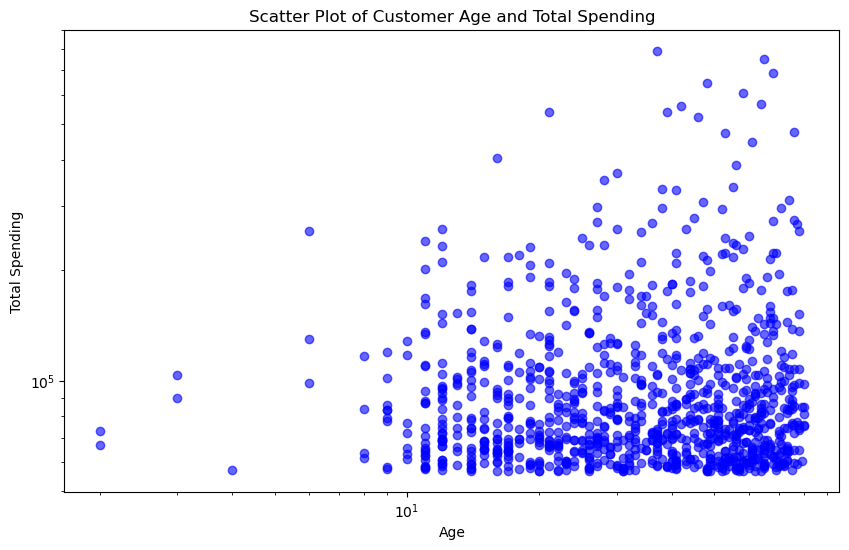

In [17]:
from pyspark.sql.functions import to_date, collect_list
import matplotlib.pyplot as plt
import numpy as np


current_year = datetime.now().year

df_u_s_1 = df_u_s.withColumn("dob", to_date(col("dob"), "d-M-yyyy"))


df_u_s_2 = df_u_s_1.withColumn("age", current_year - year(col("dob")))


df_u_s_3 = df_u_s_2.select("user_id", "age").distinct()

total_spending_per_customer = df_u_s_2.groupBy("user_id").agg(_sum("price").alias("total_spending"))


df_joined = df_u_s_3.join(total_spending_per_customer, "user_id")

top_customers = df_joined.orderBy(col("total_spending").desc()).limit(1000)
top_customers.show()

plot_data = top_customers.select("age", "total_spending").toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(plot_data['age'], plot_data['total_spending'], alpha=0.6, color='blue')

plt.xlabel('Age')
plt.ylabel('Total Spending')
plt.title('Scatter Plot of Customer Age and Total Spending')

plt.xscale('log')
plt.yscale('log')

plt.show()

### Part 3 RDDs vs DataFrame vs Spark SQL (15%) <a class="anchor" name="part-3"></a>
Implement the following queries using RDDs, DataFrames in SparkSQL separately. Log the  time taken for each query in each approach using the “%%time” built-in magic command in Jupyter Notebook and discuss the performance difference between these 3 approaches. 


#### Query: Find top 100 most popular products (by total sales) among user age group 20-40, group by brand, and show total sales of each brand.

#### 3.1. RDD Implementation

In [22]:
%%time

def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%d-%m-%Y')
    current = datetime.now()
    age = (current.year - dob.year) - ((current.month, current.day) < (dob.month, dob.day))
    return age if 20 <= age <= 40 else None


rdd_product_mapped = rdd_p_1.map(lambda row: (row[0], row[2]))

rdd_sales_mapped = rdd_s_1.map(lambda line: (line[2], (float(line[3]), line[4])))

rdd_users_filtered = rdd_u_1.map(lambda row: (row[0], calculate_age(row[1]))).filter(lambda row: row[1] is not None)

rdd_sales_product_joined = rdd_sales_mapped.join(rdd_product_mapped)


rdd_sales_user_brand_keyed = rdd_sales_product_joined.map(lambda x: (x[1][0][1], (x[1][1], x[1][0][0])))


rdd_sales_product_users_joined = rdd_sales_user_brand_keyed.join(rdd_users_filtered)

rdd_brand_price = rdd_sales_product_users_joined.map(lambda x: (x[1][0][0], x[1][0][1]))


rdd_result = rdd_brand_price.reduceByKey(lambda x, y: x + y)

results = rdd_result.collect()
top_100_brands_rdd = sorted(results, key=lambda x: -x[1])[:100]
for brand, total_sales in top_100_brands_rdd:
    print(brand, total_sales)


apple 593698657.6400007
samsung 255476588.96999964
 98251532.74999997
xiaomi 56788821.05999998
huawei 25887929.19999993
lg 23401199.149999987
lucente 17959777.029999997
sony 17511943.569999997
acer 17056048.999999996
oppo 16905138.950000014
lenovo 14158153.290000012
asus 8298681.059999996
hp 7721289.320000001
bosch 7247063.709999999
artel 6085680.1400000015
indesit 5338787.870000002
haier 4655269.719999999
beko 3491091.620000003
dauscher 3444235.449999999
philips 2746115.9999999995
vivo 2671477.8200000017
pulser 2493706.5799999996
midea 2463724.5900000012
janome 2113614.64
tefal 1976491.170000001
canon 1879335.0499999998
karcher 1856564.6299999997
thermomix 1837307.5000000005
arg 1822162.2699999975
tcl 1732663.9200000006
dinastia 1701323.2400000005
redmond 1689498.04
dyson 1630225.330000001
cordiant 1606842.4799999977
sokolov 1568032.3999999994
hansa 1458488.6200000003
casio 1438624.5100000005
epson 1421650.4399999995
kivi 1298767.1799999995
force 1258659.8599999999
yamaha 1187044.28
m

#### 3.2. DataFrame Implementation

In [19]:
%%time
from pyspark.sql.functions import month, dayofmonth, datediff, current_date

df_u = df_u.withColumn("dob", to_date(col("dob"), "d-M-yyyy"))
df_u = df_u.withColumn("age", (datediff(current_date(), col("dob")) / 365.25).cast("integer"))

df_users_age_filtered = df_u.filter((col("age") >= 20) & (col("age") <= 40))

df_joined = df_s.join(df_p, "product_id").join(df_users_age_filtered, "user_id")

df_result = df_joined.groupBy("brand").agg(_sum("price").alias("total_sales")).orderBy(col("total_sales").desc()).limit(100)

df_result.show(100)


+----------+--------------------+
|     brand|         total_sales|
+----------+--------------------+
|     apple|  5.93698658036619E8|
|   samsung|2.5547658846927416E8|
|      NULL| 9.825153245957093E7|
|    xiaomi| 5.678882103813827E7|
|    huawei|2.5887929145560265E7|
|        lg|2.3401199162873507E7|
|   lucente|  1.79597770189085E7|
|      sony| 1.751194356247425E7|
|      acer|1.7056048943193436E7|
|      oppo|1.6905138894943237E7|
|    lenovo|1.4158153274740696E7|
|      asus|    8298681.02997303|
|        hp|    7721289.31180954|
|     bosch|   7247063.709105015|
|     artel|   6085680.125947952|
|   indesit|   5338787.866197586|
|     haier|     4655269.7056427|
|      beko|  3491091.6361312866|
|  dauscher|   3444235.436990261|
|   philips|  2746115.9831659794|
|      vivo|  2671477.8104400635|
|    pulser|    2493706.57346344|
|     midea|  2463724.5845422745|
|    janome|   2113614.632873535|
|     tefal|  1976491.1577763557|
|     canon|  1879335.0481834412|
|   karcher|  

#### 3.3. Spark SQL Implementation

In [20]:
%%time

df_u = df_u.withColumn("dob", to_date(col("dob"), "d-M-yyyy"))
df_u = df_u.withColumn("age", (datediff(current_date(), col("dob")) / 365.25).cast("integer"))

df_u.createOrReplaceTempView("users")
df_s.createOrReplaceTempView("sales")
df_p.createOrReplaceTempView("product")

sql_query = """
SELECT p.brand, SUM(s.price) as total_sales
FROM sales s
JOIN product p ON s.product_id = p.product_id
JOIN users u ON s.user_id = u.user_id
WHERE u.age BETWEEN 20 AND 40
GROUP BY p.brand
ORDER BY total_sales DESC
LIMIT 100
"""

df_sql_result = spark.sql(sql_query)
df_sql_result.show(100)

+----------+--------------------+
|     brand|         total_sales|
+----------+--------------------+
|     apple|  5.93698658036619E8|
|   samsung|2.5547658846927416E8|
|      NULL| 9.825153245957093E7|
|    xiaomi| 5.678882103813827E7|
|    huawei|2.5887929145560265E7|
|        lg|2.3401199162873507E7|
|   lucente|  1.79597770189085E7|
|      sony| 1.751194356247425E7|
|      acer|1.7056048943193436E7|
|      oppo|1.6905138894943237E7|
|    lenovo|1.4158153274740696E7|
|      asus|    8298681.02997303|
|        hp|    7721289.31180954|
|     bosch|   7247063.709105015|
|     artel|   6085680.125947952|
|   indesit|   5338787.866197586|
|     haier|     4655269.7056427|
|      beko|  3491091.6361312866|
|  dauscher|   3444235.436990261|
|   philips|  2746115.9831659794|
|      vivo|  2671477.8104400635|
|    pulser|    2493706.57346344|
|     midea|  2463724.5845422745|
|    janome|   2113614.632873535|
|     tefal|  1976491.1577763557|
|     canon|  1879335.0481834412|
|   karcher|  

### 3.4 Observe the query execution time among RDD, DataFrame, SparkSQL, which is the fastest and why? (Maximum 500 words.)

Based on the execution times , the order of speed is SparkSQL(fastest), DataFrame, and then RDD(slowest). 
Here is the reason:

SparkSQL (13.6s): 
SparkSQL is the fastest for most of the time, because it use something call "Catalyst optimizer", which is a very efficient query optimizer. It converts queries into an execution plan. 
This plan will be optimized for efficiency based on some factors like data distribution, partitioning, and available resources. It also takes advantage on the Tungsten's efficient memory & code generation enhancements, which will also help on improving the performance.

DataFrame (15.4s): 
The DataFrame API in Spark also benefits from the Catalyst optimizer and Tungsten for efficient execution. But when writing queries in the DataFrame API, there could be a bit of overhead compared to SparkSQL due to the method calls and lambda functions used, which is why it is slightly longer to execution compared to SparkSQL.

RDD (1min 20s): 
RDDs are the lowest level API in Spark and it allows user to have the most control on the data and transformations. But they are lacking the optimization layers present in SparkSQL and DataFrames, like the Catalyst optimizer and Tungsten. RDD operations are more Java based and it involves more overhead especially in serialization and deserialization. They are also lacking the smart optimizations for joins, filters, and aggregations that the higher-level APIs provide. As a result, operations with RDDs will be slower, especially for complex queries on larger datasets.

In summary, SparkSQL's speed advantage from its advanced optimization features and the ability to translate SQL queries into highly optimized execution plans. DataFrames are also at the fast side, it benefits from the same optimization engine, while RDDs are slower because of lacking on these optimizations and higher operational overhead.

#### Summary

The time might differ when running on different machines. Overall, the DataFrame and SQL queries run ...... compared with RDD.


### Some ideas on the comparison

Armbrust, M., Huai, Y., Liang, C., Xin, R., & Zaharia, M. (2015). Deep Dive into Spark SQL’s Catalyst Optimizer. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html

Damji, J. (2016). A Tale of Three Apache Spark APIs: RDDs, DataFrames, and Datasets. Retrieved September 28, 2017, from https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html

Data Flair (2017a). Apache Spark RDD vs DataFrame vs DataSet. Retrieved September 28, 2017, from http://data-flair.training/blogs/apache-spark-rdd-vs-dataframe-vs-dataset

Prakash, C. (2016). Apache Spark: RDD vs Dataframe vs Dataset. Retrieved September 28, 2017, from http://why-not-learn-something.blogspot.com.au/2016/07/apache-spark-rdd-vs-dataframe-vs-dataset.html

Xin, R., & Rosen, J. (2015). Project Tungsten: Bringing Apache Spark Closer to Bare Metal. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/28/project-tungsten-bringing-spark-closer-to-bare-metal.html